# Transfer learning


In [ ]:
# nos aseguramos de trabajar con tensor 2 utilizando la gpu
!pip install tensorflow-gpu==2.0.0-beta1

In [5]:
# Conceder acceso a Drive para utilizar los archivos 
# alojados allí (solo si se va a correr en colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from preprocess_images import Preprocesar_imagenes
from sklearn.model_selection import train_test_split,RandomizedSearchCV

In [ ]:
class Modelo_tl():

  def __init__(self,path):    
    # verificación de disponibilidad de GPU
    if(tf.test.is_gpu_available()):
      print("GPU disponible para entrenar el modelo")
    else:
      print("No hay GPU disponible")
      
    self.path_proyecto = path
    
  def cargar_dataset(self):
    cargar_archivo = Preprocesar_imagenes(self.path_proyecto)
    return cargar_archivo.load_dataset(self.path_proyecto+"base_redimensionada")
  
  def one_hot_y(self,y):    
    return to_categorical(y)  
  
  def particion_dataset(self,X,y):    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=y, 
                                                        test_size=0.2,
                                                        random_state=77)       
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                     stratify=y_train, 
                                                     test_size=0.1, 
                                                     random_state=77)      
    
    return X_train,X_val,X_test,y_train,y_val,y_test
  
  def normalizar_imagenes(self,train,val,test):    
    """
    normalizamos los pixeles a valores entre 0 y 1 
    """
    train_images, val_images, test_images = train / 255.0, val / 255.0 , test / 255.0
    
    return train_images, val_images, test_images
  
  def arquitectura_modelo(self,neuronas_capas_densa=64,capas_densas=2,learning_rate=0.001,capas_a_descongelar=0):
    print("Compilando modelo...")
    image_size = 64
    img_shape = (image_size,image_size,3)

    # weights selecciona los pesos que se obtuvo cuando se entrenó con el dataset imagenet
    # include_top = solo la parte de las capas convolucionales
    # y luego pasamos la dimensión de entrada de nuestra red

    # base_model = tf.keras.applications.ResNet50(input_shape=img_shape,
    #                                              include_top=False,
    #                                              weights='imagenet')
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                                  include_top=False,
                                                  weights='imagenet')
    
    base_model.trainable = True

    for layer in base_model.layers[:capas_a_descongelar]:
      layer.trainable =  False
      
    model = keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(neuronas_capas_densa, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
        
    for i in range(capas_densas):
      model.add(layers.Dense(neuronas_capas_densa, activation='relu')) 
      model.add(keras.layers.Dropout(0.2))
        
    model.add(keras.layers.Dense(18, activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  
    return model
  
  def train(self,modelo,X_train,y_train,X_val=None,y_val=None,epocas=50,lote=32):   
    """
    Se entrena un modelo con la arquitectura definida y se retorna el modelo
    y los datos históricos del entrenamiento
    """ 
    es = keras.callbacks.EarlyStopping(patience=7,verbose=1,monitor='val_accuracy')
    rp = keras.callbacks.ReduceLROnPlateau(patience=5,factor=0.5,verbose=1,monitor='val_accuracy')
    # cp = keras.callbacks.ModelCheckpoint("mejor_modelo.h5", save_best_only=True)
       
    if X_val is None or y_val is None:      
      history = modelo.fit(X_train, y_train, epochs=epocas,batch_size = lote,
                        validation_split=0.1,
                        callbacks=[es,rp])
    else:
      history = modelo.fit(X_train, y_train, epochs=epocas,batch_size = lote,
                  validation_data=(val_images,y_val),
                  callbacks=[es,rp])

    return history,modelo
  
  def tunning_modelo(self,X_train,y_train,X_val,y_val):
    """
    TODO, que los parámetros de tunning se pasen por parametros y no estén quemados
    pero me da pereza
    """
    #K.set_image_dim_ordering('th')
    np.random.seed(77)
    
    keras_class = keras.wrappers.scikit_learn.KerasClassifier(self.arquitectura_modelo)

    # tener en cuenta que la puntuación será la opuesta a la del crossentropy
    # porque Scikit-Learn desea puntuaciones, no pérdidas. (es decir, más alto debería ser mejor).
    
    param_distribs = {
        "neuronas_capas_densa": [64,128,256,512],
        "capas_a_descongelar": [0,10,20,30],
        "capas_densas": [1,2,3],
        "learning_rate": [0.001,0.005,0.0001]
    } 
    
    cnn_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=50, cv=2, verbose=2)

    cnn_search_cv.fit(X_train, y_train, epochs=150,   
                      validation_data = (X_val,y_val),                
                      callbacks=[keras.callbacks.EarlyStopping(patience=8,verbose=1,monitor='val_accuracy')
                                 ,keras.callbacks.ReduceLROnPlateau(patience=5,verbose=1,monitor='val_accuracy')])
    
    return cnn_search_cv

In [26]:
# ubicación del proyecto
path = "/content/drive/My Drive/Synced/u/predictive/Solucion_taller_1/"
modelo = Modelo_tl(path)

GPU disponible para entrenar el modelo


In [ ]:
# Carga y partición de dataset
X,y,nombres = modelo.cargar_dataset()
X_train,X_val,X_test,y_train,y_val,y_test = modelo.particion_dataset(X,y)
train_images, val_images, test_images = modelo.normalizar_imagenes(X_train,X_val,X_test)

In [ ]:
model_tuning = modelo.tunning_modelo(train_images,y_train,val_images,y_val)

In [ ]:
model_tuning.best_params_

In [12]:
modelo_transfer = modelo.arquitectura_modelo(32,1,0.0005,capas_a_descongelar=0)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


## Transfer Learning 
### Arquitectura: ResNet50

In [ ]:
resnet_history,resnet_model = modelo.train(modelo_transfer,train_images,y_train,val_images,y_val,epocas=100,lote=32)

In [16]:
resnet_model.evaluate(test_images,y_test)

5364/5364 [==============================] - 8s 2ms/sample - loss: 0.9344 - accuracy: 0.8678


[0.9344425087740491, 0.8678225]

In [ ]:
resnet_model.save("modelo_bueno_resnet.h5")

In [ ]:
losses = {key:resnet_history.history[key] for key in ['loss', 'val_loss']}
accuracy = {key:resnet_history.history[key] for key in ['accuracy', 'val_accuracy']}

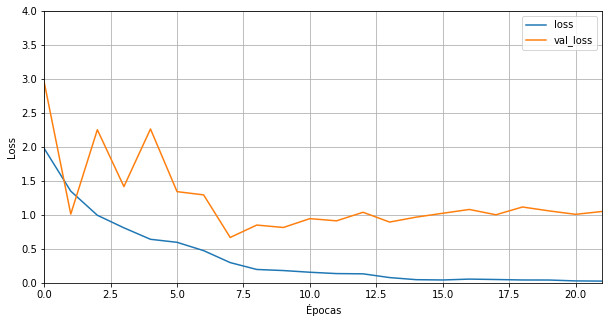

In [20]:
pd.DataFrame(losses).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 4)
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

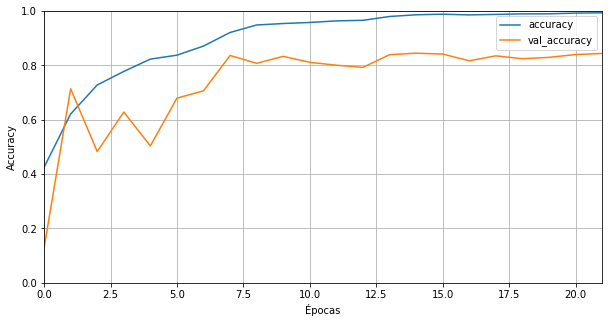

In [21]:
pd.DataFrame(accuracy).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 1)
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Arquitectura MobileNetV2

In [ ]:
# ubicación del proyecto
path = "/content/drive/My Drive/Synced/u/predictive/Solucion_taller_1/"
modelo = Modelo_tl(path)

In [ ]:
modelo_transfer_2 = modelo.arquitectura_modelo(32,1,0.0005,capas_a_descongelar=0)

In [ ]:
movilNet_history,modelo_movilNet = modelo.train(modelo_transfer_2,train_images,y_train,val_images,y_val,epocas=100,lote=32)

In [ ]:
modelo_movilNet.save("modelo_bueno_mobilnet.h5")

In [35]:
modelo_movilNet.evaluate(test_images,y_test)

5364/5364 [==============================] - 4s 743us/sample - loss: 0.5213 - accuracy: 0.9223


[0.5213358281180479, 0.9222595]

In [ ]:
losses = {key:movilNet_history.history[key] for key in ['loss', 'val_loss']}
accuracy = {key:movilNet_history.history[key] for key in ['accuracy', 'val_accuracy']}

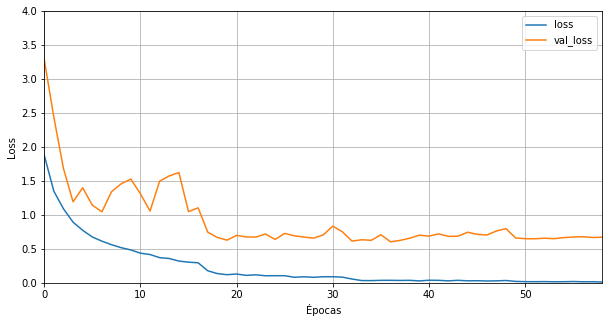

In [33]:
pd.DataFrame(losses).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 4)
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

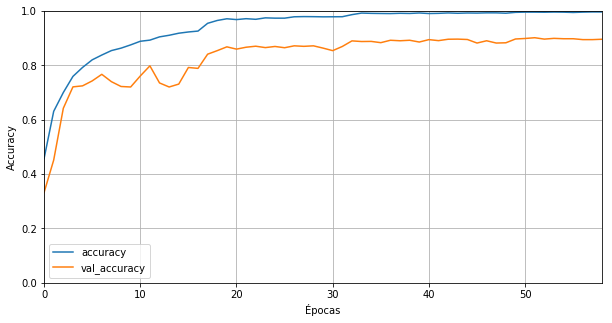

In [34]:
pd.DataFrame(accuracy).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 1)
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Conclusiones:

- MobileNetV2: 92.2 %
- ResNet50:    86.78 %

ToDo:

* Image Augmentation 
* Más técnicas de regularización para evitar el sobreajuste actual
* Descongelamiento gradual de las capas de las arquitecturas originales
